## 2024 07/10 Wrinkle Engineering

*Last Updated*: 2024-07-10

### Authors
* Nicole Tin


### Overview
An attempt to characterize wrinkle, roughness, and explore output texture maps in hand images. 

### Key Results
- ...

### Continuing Thoughts 
- ...

In [2]:
# -- Imports
import os
import cv2
import pandas as pd
from dermaml import features
from dermaml import image

# from dermaml import data
# import PIL
# from PIL import Image
# import mlflow # creates error
import matplotlib.pyplot as plt
# import skimage

# -- Feature Eng Imports
import numpy as np
import skimage
import pyfeats


In [3]:
# Dataset
dataset_name = "11khands"

# AutoML
experiment_name = "11khands-automl-sample-test_NT"
num_best_models = 5
random_seed = 42

# Paths
root = '/Users/nicole/Documents/GitHub/DermaML'
image_folder = '/data/source/Hands/'
csv_file = '/data/source/HandInfo.csv'

In [4]:
# -- Read the CSV file
df = pd.read_csv(root+ csv_file)
dorsals = df.loc[df['aspectOfHand'] == 'dorsal right']
dorsals = dorsals.drop_duplicates(subset=['id'])

## -- subset images further: 3 of each skin color
dorsals = dorsals.groupby('skinColor').tail(3)

In [5]:
# -- Read Images

def read_local(image_fnames, image_dir):
    images = []
    for filename in image_fnames:
        img = cv2.imread(os.path.join(image_dir, filename))
        if (img is not None) & (len(img.shape) > 2):
            images.append(img)
    return images

# ds = hub.load('hub://activeloop/11k-hands')
# images = ds.images

image_fnames = dorsals.loc[:, 'imageName']
images = read_local(image_fnames, root+image_folder)

In [81]:
# -- Image Preprocessing (brightness)

def remove_brightness(image):
    '''
    Converts an RGB-channeled image to HSV/HSB and removes the 'value' or 'brightness' channel.

    Arguments
    ---------
    `image`: an RGB numpy array
    '''
    assert len(image.shape) == 3
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_image[:, :, 2] = 0
    return hsv_image

iso_images = [image.remove_background(im) for im in images]
hs_images = [remove_brightness(im) for im in images]


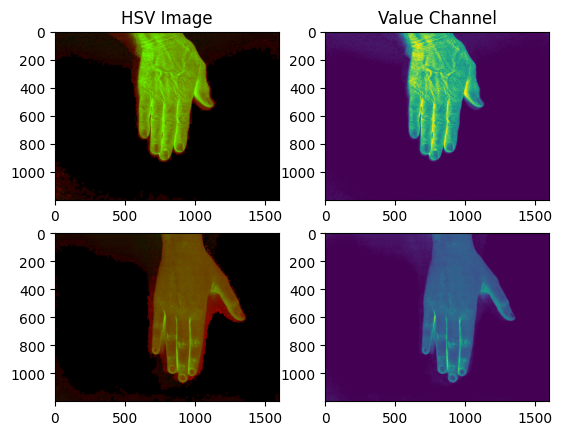

In [6]:
fig, ax = plt.subplots(2, 2)
ax[0,0].set_title('HSV Image')
ax[0,1].set_title('Value Channel')
ax[0,0].imshow(hs_images[0])
ax[0,1].imshow(hs_images[0][:,:,1])
ax[1,0].imshow(hs_images[1])
ax[1,1].imshow(hs_images[1][:,:,1])

## Visualize Texture Maps

In [30]:
im_idx = 0
bw_im  = hs_images[im_idx][:,:,1]


### GLCM
  
output map not really useful as a feature, good exploratory analysis 

In [88]:
texture_res = skimage.feature.graycomatrix( #FIXME : choice of kernel size
        bw_im, [1, 1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)

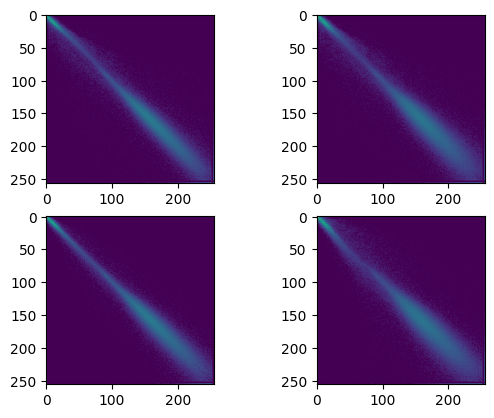

In [89]:
log_texture = lambda tex: (np.log(tex + 1)
                           /np.max(np.log(tex + 1)))

fig, ax = plt.subplots(2, 2)
ax[0,0].imshow(log_texture(texture_res[:, :, 0, 0]))
ax[0,1].imshow(log_texture(texture_res[:, :, 0, 1]))
ax[1,0].imshow(log_texture(texture_res[:, :, 0, 2]))
ax[1,1].imshow(log_texture(texture_res[:, :, 0, 3]))

### LBP

In [55]:
radius = 3
num_points = 8 * radius

lbp = skimage.feature.local_binary_pattern(
        bw_im, num_points, radius, method="uniform"
    )

In [58]:
lbp_hist, _ = np.histogram(
        lbp.ravel(),
        bins=np.arange(0, num_points + 3),
        range=(0, num_points + 2),
        density=True,
    )

In [59]:
lbp_hist

array([0.01118177, 0.00513438, 0.00580885, 0.00577031, 0.00488073,
       0.00448698, 0.00413646, 0.00507917, 0.0060276 , 0.00764375,
       0.00854219, 0.0117724 , 0.01308542, 0.01731771, 0.00926979,
       0.01169688, 0.0073    , 0.0096776 , 0.00666042, 0.00653385,
       0.00652917, 0.00705313, 0.00711667, 0.0054849 , 0.69708698,
       0.11472292])

### LTE

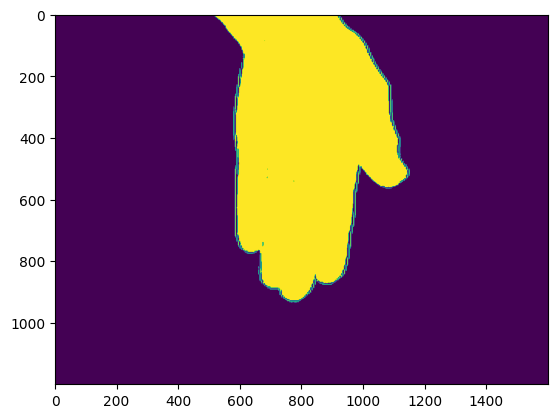

In [31]:
mask = cv2.cvtColor(iso_images[im_idx], cv2.COLOR_RGBA2GRAY) != 0

**3.1.2 Gray Level Co-occurence Matrix (GLCM/SGLDM)**  
The Gray Level Co-occurrence Matrix (GLCM) as proposed by Haralick are based on the estimation of the second-order joint conditional probability density functions. The GLGLCM features are the following: 1) angular second moment, 2) contrast, 3) correlation, 4) sum of squares: variance, 5) inverse difference moment, 6) sum average, 7) sum variance, 8) sum entropy, 9) entropy, 10) difference variance, 11) difference entropy, 12,13) information measures of correlation. For each feature, the mean values and the range of values are computed, and are used as two different features sets.

In [8]:
features_mean, features_range, labels_mean, labels_range = pyfeats.glcm_features(bw_im, ignore_zeros=True)

**3.1.3 Gray Level Difference Statistics (GLDS)**  
The Gray Level Difference Statistics (GLDS) algorithm uses first order statistics of local property values based on absolute differences between pairs of gray levels or of average gray levels in order to extract texture measures. The GLDS features are the following: 1) homogeneity, 2) contrast, 3) energy, 4) entropy, 5) mean.

In [32]:
features, labels = pyfeats.glds_features(bw_im, mask, Dx=[0,1,1,1], Dy=[1,1,0,-1])

**3.1.4 Neighborhood Gray Tone Difference Matrix (NGTDM)**  
Neighbourhood Gray Tone Difference Matrix (NDTDM) corresponds to visual properties of texture. The NGTDM features are the following: 1) coarseness, 2) contrast, 3) busyness, 4) complexity, 5) strength.

In [33]:
features, labels = pyfeats.ngtdm_features(bw_im, mask, d=1)

**3.1.7 Fractal Dimension Texture Analysis (FDTA)**  
Fractal Dimension Texture Analysis (FDTA) is based on the Fractional Brownian Motion (FBM) Model. The FBM model is used to describe the roughness of nature surfaces. It regards naturally occurring surfaces as the end result of random walks. Such random walks are basic physical processes in our universe. One of the most important parameters to represent a fractal surface is the fractal dimension. A simpler method is to estimate the H parameter (Hurst coefficient). If the image is seen under different resolutions, then the multiresolution fractal (MF) feature vector is obtained.

In [40]:
features, labels, energy, conv = pyfeats.lte_measures(bw_im, mask,)

## Wrinkles/Roughness

### Hessian Matrix
  
Reveals folds in skin!

Need to determine a threshold value for hessian matrix

In [35]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

def detect_ridges(gray, sigma=1.0, blur = 5):
  if blur > 0:
    kernel = np.ones((blur,blur),np.float32)/25
    gray = cv2.filter2D(gray,-1,kernel)
  H_elems = hessian_matrix(gray, sigma=sigma)
  maxima_ridge, minima_ridge = hessian_matrix_eigvals(H_elems)
  return maxima_ridge, minima_ridge

/var/folders/m7/85df1_cn7kn2pl6kpn8bhrs40000gn/T/ipykernel_1064/78239787.py:7: FutureWarning: use_gaussian_derivatives currently defaults to False, but will change to True in a future version. Please specify this argument explicitly to maintain the current behavior
  H_elems = hessian_matrix(gray, sigma=sigma)


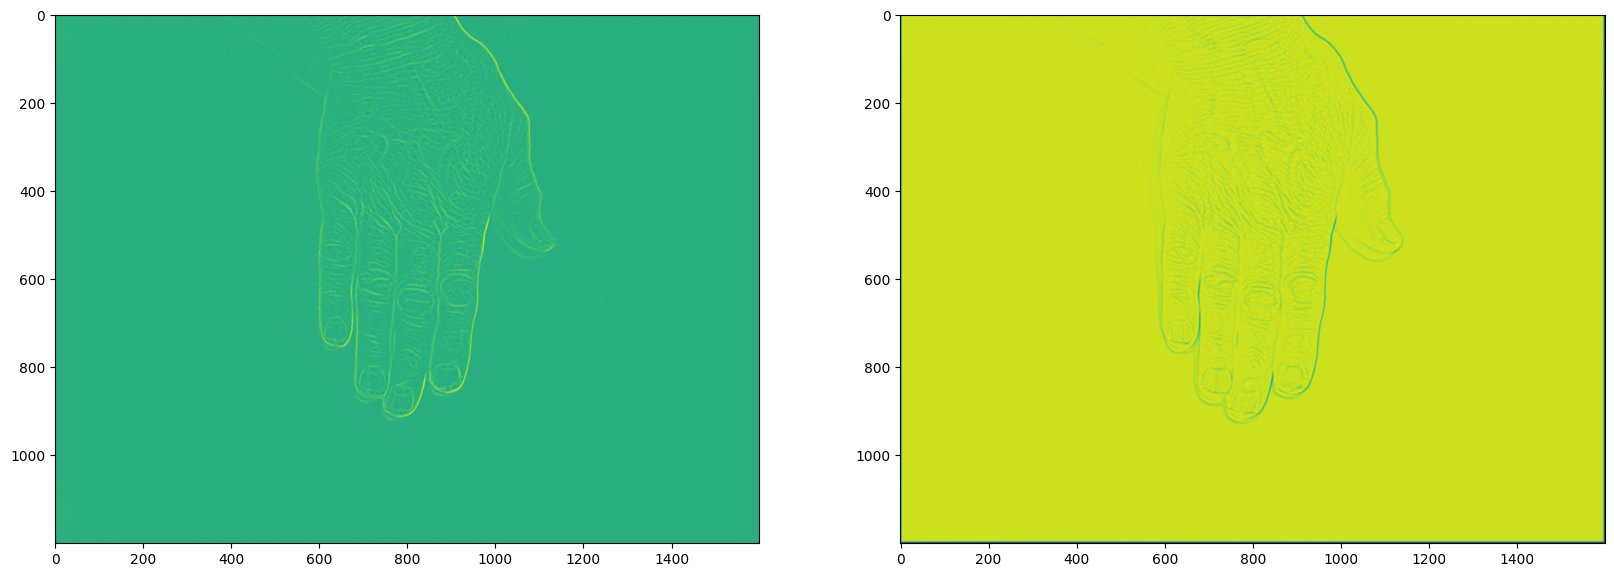

In [36]:
a, b = detect_ridges(bw_im)


fig, ax = plt.subplots(1, 2, figsize=(20, 12))
ax[0].imshow(a)
ax[1].imshow(b)


/var/folders/m7/85df1_cn7kn2pl6kpn8bhrs40000gn/T/ipykernel_1064/78239787.py:7: FutureWarning: use_gaussian_derivatives currently defaults to False, but will change to True in a future version. Please specify this argument explicitly to maintain the current behavior
  H_elems = hessian_matrix(gray, sigma=sigma)


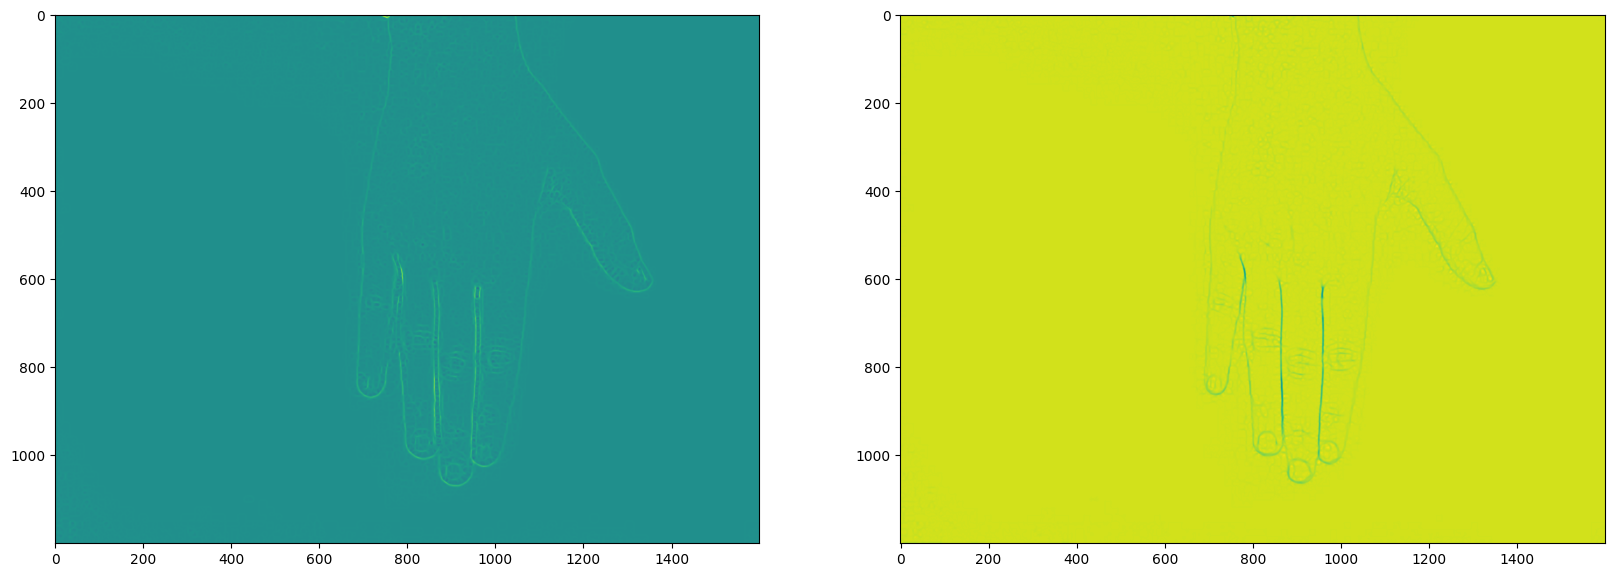

In [37]:
a2, b2 = detect_ridges(hs_images[1][:,:,1])

fig, ax = plt.subplots(1, 2, figsize=(20, 12))
ax[0].imshow(a2)
ax[1].imshow(b2)

In [68]:
np.mean(b), np.std(b)

(-0.0012478073728138211, 0.008246767162177744)

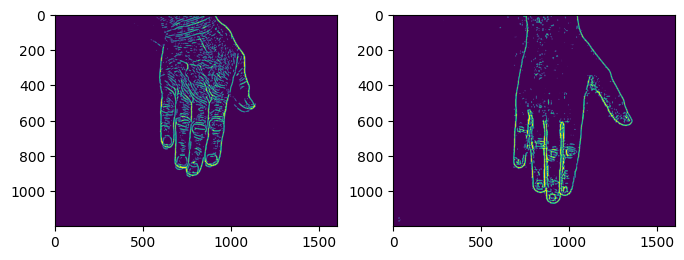

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(8,12))
# a_lim = 0.005
a_lim = lambda a : np.mean(a) + 2*(np.std(a))
# a_lim = 0
ax[0].imshow(a >= a_lim(a))
ax[1].imshow(a2 >= a_lim(a2))

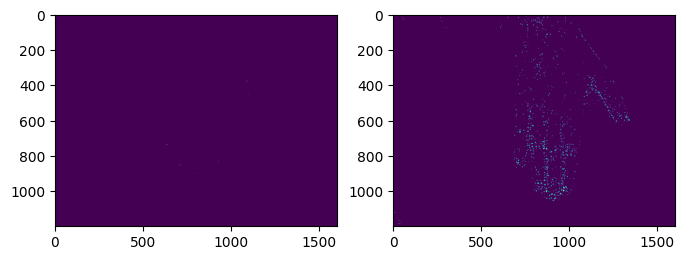

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(8,12))
# b_lim = 0.0006
b_lim = lambda b: np.mean(b) + (np.std(b))
ax[0].imshow(b >= b_lim(b))
ax[1].imshow(b2 >= b_lim(b2))

In [73]:
old = np.count_nonzero(hs_images[0][:,:,1])
q = np.count_nonzero(a >a_lim(a))
# w = np.count_nonzero(b > b_lim)

young = np.count_nonzero(hs_images[1][:,:,1])
z = np.count_nonzero(a2>a_lim(a2))
# x = np.count_nonzero(b2 > b_lim)


print(f'old nums: \n total {old},  \n wrinkle {q}, {w},')
print(f'\n young nums: \n total {young},  \n wrinkle {z}, {x}, ')
print(f'\n \n old ratios: {q/old}, {w/old} \n young ratio: {z/young}, {x/young}')

old nums: 
 total 681499,  
 wrinkle 63097, 57363,

 young nums: 
 total 708626,  
 wrinkle 50283, 34173, 

 
 old ratios: 0.09258560907646232, 0.08417180362700459 
 young ratio: 0.07095844634546292, 0.04822431014385586


## Relative Redness

In [69]:
low_H = 0
high_H = 10
low_H2 = 170
high_H2 = 180
low_S = 70
high_S = 255
low_V = 0
high_V = 255

# hsv = cv2.cvtColor(images[0], cv2.COLOR_BGR2HSV)
# red_1 = cv2.inRange(hsv, (low_H, low_S, low_V), (high_H, high_S, high_V))
# red_2 = cv2.inRange(hsv, (low_H2, low_S, low_V), (high_H2, high_S, high_V))

i = 0
red_1 = cv2.inRange(hs_images[i], (low_H, low_S, low_V), (high_H, high_S, high_V))
red_2 = cv2.inRange(hs_images[i], (low_H2, low_S, low_V), (high_H2, high_S, high_V))

h = hs_images[0][:,:, 0]
np.min(h), np.max(h)

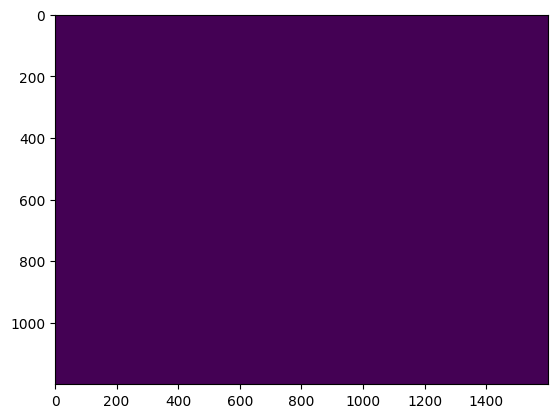

In [70]:
plt.imshow(red_1|red_2)

In [84]:
red_channel = cv2.cvtColor(iso_images[1], cv2.COLOR_BGR2RGB)[:,:,0]

In [83]:
np.mean(red_channel), np.std(red_channel)

(20.023273958333334, 43.926334830670775)

In [85]:
np.mean(red_channel), np.std(red_channel)

(38.94232291666667, 78.36340182936621)

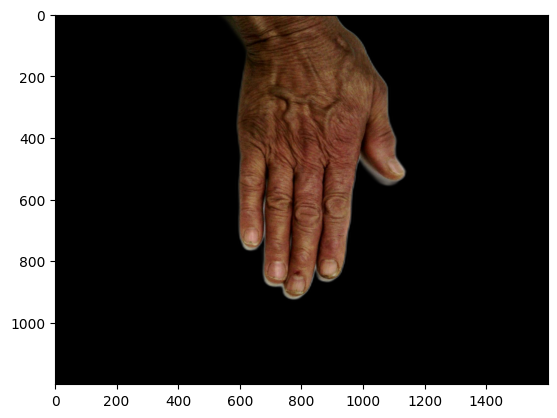

In [79]:
plt.imshow()